This code uses the freud package, alongwith PyLammps, to calculate the averaged structure factor for a generic system over a user-defined range of snapshots in a lammps trajectory file.

In [1]:
import numpy as np
import time
from cycler import cycler
import matplotlib
from matplotlib import pyplot
from matplotlib.colors import colorConverter
myHexColors = ["#30A2DA", "#FC4F30", "#E5AE38", "#6D904F", "#9757DB", "#188487", "#FF7F00", "#9A2C66", "#626DDA", "#8B8B8B"]
myColorCycle = [colorConverter.to_rgb(i) for i in myHexColors]
from freud import parallel
parallel.setNumThreads(4)

from ipywidgets import IntProgress
from IPython.display import display

# matplotlib.rcParams.update({'font.sans-serif': 'Helvetica'})
# matplotlib.rcParams.update({'font.family': 'sans-serif'})
matplotlib.rcParams.update({'font.size': 24})
matplotlib.rcParams.update({'axes.labelsize': 24})
matplotlib.rcParams.update({'xtick.labelsize': 18})
matplotlib.rcParams.update({'ytick.labelsize': 18})
matplotlib.rcParams.update({'savefig.pad_inches': 0.025})
matplotlib.rcParams.update({"axes.prop_cycle": cycler(color=myColorCycle)})
matplotlib.rcParams.update({"lines.linewidth": 2})

# lammps
from lammps import lammps, PyLammps
lmp = lammps()
L = PyLammps(ptr=lmp) # Get PyLammps

LAMMPS output is captured by PyLammps wrapper


All the user-defined stuff is in the next cell. Update the name of your trajectory file accordingly. It should be inside the subfolder traj. If you specify a frame that is not present in the lammps trajectory file, PyLammps will throw an error. 
TODO: Read these from an input file?

In [2]:
# User-defined stuff
system = 'fcc'
typeID = 1
frameNo = 500000 #500000
endFrame = 515000 #1000000
dumpFreq = 5000 #1000 #5000
nFrames = int((endFrame - frameNo)/dumpFreq) 
# Dumpfile name to read from 
dumpfile = 'traj/dump-' + system + '.lammpstrj'
# Define the no. of grid points in each dim: 2*g+1
grid = 25

Average the structure factor over the frames specified by frameNo and endFrame (inclusive of both). If you specify a frame that is not present in the lammps trajectory file, PyLammps will throw an error.

If you run the cell below more than once, make sure to uncomment the PyLammps command for reading in the data file, or else you will get a Lammps error.

IntProgress(value=1, max=3, min=1)

/home/sadanandam/miniconda3/lib/python3.6/site-packages/freud/kspace.py:144: ComplexWarning: Casting complex values to real discards the imaginary part
  np.float32)


Frame number  505000
Frame number  510000
Frame number  515000
time to calc 3 frames = 46.71709871292114
speed of calc: 0.06421631656612811 (frames/sec)


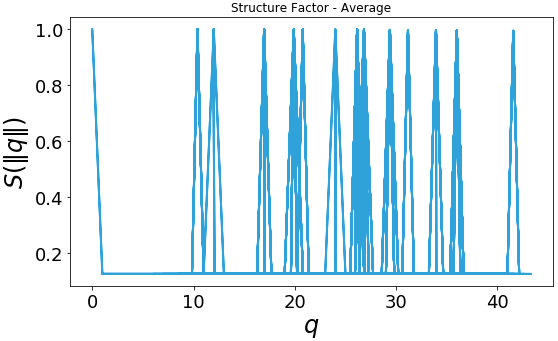

In [3]:
# import the freud object
# the rdf module is contained in the density module
from freud import box, kspace

# Current frame
frame = frameNo+dumpFreq

# compute the rdf for for all frames except the first (your syntax will vary based on your reader)
myProgressBar = IntProgress(min=1,max=nFrames)
display(myProgressBar)

# Lammps init
# load the data
# Read in the lammps input file
lmp.file('lammpsFiles/inp.'+ system) # LAMMPS input file for the system
# Get the number of atoms of one typeID
natoms = 0
L.read_dump(dumpfile, frameNo, "x y z box yes replace yes")
for i in range(L.atoms.natoms):
    if L.atoms[i].type==typeID:
        natoms += 1
# Define numPy coordinate array; here natoms is the no. of atoms of type 1
x = np.zeros((natoms,3), dtype=float)

# Get the simulation box from PyLammps
box_limits = [L.system.xhi-L.system.xlo, L.system.yhi-L.system.ylo, L.system.zhi-L.system.zlo] # box from lammps
# --------------------------------
# Compute the structure factor for the first step specified by frameNo
# create the freud box object
fbox = box.Box(Lx=box_limits[0], Ly=box_limits[1], Lz=box_limits[2]) 

# create the structure factor object
# g defines the no. of grid points = 2*g+1
strucFactor = kspace.SFactor3DPoints(box=fbox,g=grid) 
# compute 3-D static structure factor
strucFactor.compute(x)
# get the value of the histogram bins of the structure factor
S = strucFactor.getS()
# Create the object for the 1-D analog of the 3-D structure factor
stucOneD = kspace.AnalyzeSFactor3D(S)
# Get a list of all S(∣∣q∣∣) values vs q2.
sMod, q2 = stucOneD.getSvsQ()
# Take the square root of q2 to get q
q = np.sqrt(q2)

# --------------------------------
start_time = time.time()
for i in range(nFrames):
    # Progress bar
    myProgressBar.value = int(frame/dumpFreq)
    # --------------------------
    # Lammps stuff
    # read box, position data from the lammps dumpfile
    L.read_dump(dumpfile, frame, "x y z box yes replace yes")
    # Get coord
    # Assigning values to numpy array x
    for i in range(L.atoms.natoms):
        if L.atoms[i].type==typeID:
            for k in range(3):
                x[i][k] = L.atoms[i].position[k]          
    box_limits = [L.system.xhi-L.system.xlo, L.system.yhi-L.system.ylo, L.system.zhi-L.system.zlo] # box from lammps
    # --------------------------
    # create the freud box object
    fbox = box.Box(Lx=box_limits[0], Ly=box_limits[1], Lz=box_limits[2])    

    # compute 3-D static structure factor
    strucFactor.compute(x)
    
    # get the value of the histogram bins of the structure factor
    S = strucFactor.getS()
    
    # Create the object for the 1-D analog of the 3-D structure factor
    stucOneD = kspace.AnalyzeSFactor3D(S)
    
    # Get a list of all S(∣∣q∣∣) values vs q2.
    sModOne, q2 = stucOneD.getSvsQ()
    # Take the square root of q2 to get q
    qOne = np.sqrt(q2)
    
    # Average output over previous frames
    sMod = 0.5*(sMod + sModOne)
    q = 0.5*(qOne + q)

    # ----------------------------
    # Update frame number
    print("Frame number ", frame)
    frame = frame + dumpFreq
stop_time = time.time()
print("time to calc {} frames = {}".format(nFrames, stop_time-start_time))
print("speed of calc: {} (frames/sec)".format((nFrames)/(stop_time-start_time)))

pyplot.figure(figsize=(8, 5))
pyplot.title("Structure Factor - Average")
pyplot.plot(q, sMod)
pyplot.xlabel(r"$q$")
pyplot.ylabel(r"$S\left( \Vert q \Vert \right)$")
pyplot.tight_layout()
pyplot.show()
